In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime

In [4]:
df = pd.read_csv('revs_scored_jan.tsv', sep='\t', header=0)

In [5]:
days = df.rev_timestamp.map(lambda ts: datetime.utcfromtimestamp(ts).day)
df['day'] = days

In [6]:
# isolate data to only data from Jan1-Jan21, reverted w/in 24 hours, revisions by a bot

sdf = df[df.day<22]
sdf_reverted = sdf[sdf.is_reverted] # w/o, still include 'none'
sdf_reverted_in_day = sdf_reverted[sdf_reverted.seconds_to_revert.astype('str').astype('int')<86400]
sdf_bots = sdf_reverted_in_day[sdf_reverted_in_day.user_is_bot]

In [7]:
# isolate namespace 0

namespace0 = sdf_bots[sdf_bots.page_namespace == 0]

# graph bot pairs with colors indicating self-reverts

In [8]:
# to do next: find matching rev_id to revert_ids of where user_is_bot is true?
sdf_another = df[df.user_is_bot]
sdf_another = sdf_another[sdf_another.is_revert]

sdf1 = namespace0.loc[namespace0.is_reverted, ["rev_id", "user_text", "revert_id"]]
sdf1.revert_id = sdf1.revert_id.astype('int')

sdf2 = sdf_another[["rev_id", 'user_text', "is_self_revert"]]

In [9]:
# subset bot-bot reverts using merge

bot_bot_reverts = pd.merge(sdf1, sdf2, 
             how='inner', 
             left_on='revert_id', 
             right_on='rev_id', 
             suffixes=('', '_reverter')
)

### discovery that data doesn't fit our definition of self reverts in is_self_revert column

In [10]:
bot_pairs = bot_bot_reverts.groupby(["user_text","user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [11]:
bot_pairs

,index,user_text,user_text_reverter,rev_id,revert_id,rev_id_reverter,is_self_revert
0,3,EmausBot,EmausBot,294,294,294,294
1,6,RMCD bot,RMCD bot,47,47,47,47
2,2,DPL bot,DPL bot,17,17,17,17
3,4,Filedelinkerbot,Filedelinkerbot,8,8,8,8
4,1,Cyberbot II,Cyberbot II,6,6,6,6
5,7,RonBot,RonBot,2,2,2,2
6,0,ClueBot NG,EmausBot,1,1,1,1
7,5,JCW-CleanerBot,JCW-CleanerBot,1,1,1,1


In [12]:
bot_bot_reverts.groupby(["user_text","user_text_reverter"], as_index = False).sum().sort_values("rev_id", ascending=False).reset_index()

,index,user_text,user_text_reverter,rev_id,revert_id,rev_id_reverter,is_self_revert
0,3,EmausBot,EmausBot,258015404640,258024564260,258024564260,290
1,6,RMCD bot,RMCD bot,41272626516,41273464584,41273464584,44
2,2,DPL bot,DPL bot,14922002776,14924556522,14924556522,17
3,4,Filedelinkerbot,Filedelinkerbot,7027773933,7027774401,7027774401,0
4,1,Cyberbot II,Cyberbot II,5271125803,5271668151,5271668151,6
5,7,RonBot,RonBot,1752468744,1752586514,1752586514,2
6,0,ClueBot NG,EmausBot,878888255,878888657,878888657,0
7,5,JCW-CleanerBot,JCW-CleanerBot,878794664,878794769,878794769,1


note: why does is_self_revert column not match up with totals in above chart? shouldn't all counted things be self-reverts if user_text and user_text_reverter match up?

In [13]:
bot_bot_reverts[(bot_bot_reverts.user_text == "EmausBot") & (bot_bot_reverts.user_text_reverter == "EmausBot") & (bot_bot_reverts.is_self_revert == False)]

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
98,877003459,EmausBot,877006852,877006852,EmausBot,False
299,878468083,EmausBot,878538474,878538474,EmausBot,False
324,878842220,EmausBot,878983569,878983569,EmausBot,False
325,878842233,EmausBot,878983590,878983590,EmausBot,False


depends on how is_self_revert is computed

if there is an intervening edit by another user, doesn't count as a self revert (in our current data)

In [14]:
bot_pairs["category_is_self_revert"] = False

for row in bot_pairs.itertuples():
    if row.user_text_reverter == row.user_text:
        bot_pairs.loc[row.Index, "category_is_self_revert"] = True

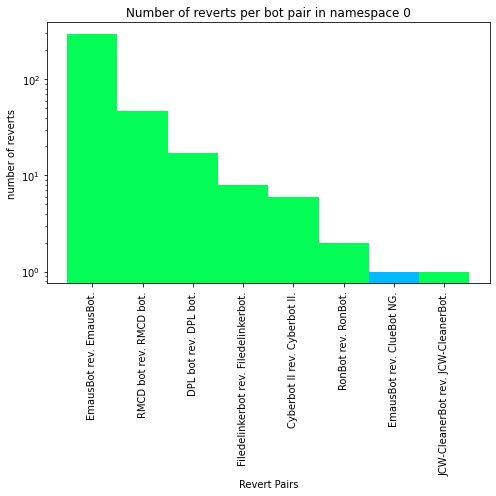

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

y = range(len(bot_pairs))

map = bot_pairs.category_is_self_revert.map(lambda is_self: '#03fc56' if is_self else '#03bafc')

axes.bar(y, bot_pairs.rev_id, width=1, color = map)

axes.set_title("Number of reverts per bot pair in namespace 0")
axes.set_xlabel("Revert Pairs")
axes.set_ylabel("number of reverts")

axes.set_yscale('log')

axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text_reverter} rev. {row.user_text}." for row in bot_pairs.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()

# graph bot reverts of humans and human reverts of bots

In [16]:
top_reverted_bots = bot_bot_reverts.groupby(["user_text"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [17]:
top_reverted_bots

,index,user_text,rev_id,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
0,3,EmausBot,294,294,294,294,294
1,6,RMCD bot,47,47,47,47,47
2,2,DPL bot,17,17,17,17,17
3,4,Filedelinkerbot,8,8,8,8,8
4,1,Cyberbot II,6,6,6,6,6
5,7,RonBot,2,2,2,2,2
6,0,ClueBot NG,1,1,1,1,1
7,5,JCW-CleanerBot,1,1,1,1,1


In [18]:
"""
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

y = range(len(top_reverted_bots))

axes.bar(y, top_reverted_bots.rev_id, width=1)

axes.set_title("Number of times each bot was reverted in namespace 0")
axes.set_xlabel("reverted bot")
axes.set_ylabel("number of times bot was reverted")

axes.set_yscale('log')

axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text}" for row in top_reverted_bots.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()
"""

'\nfig, axes = plt.subplots(1, 1, figsize=(7, 7))\n\ny = range(len(top_reverted_bots))\n\naxes.bar(y, top_reverted_bots.rev_id, width=1)\n\naxes.set_title("Number of times each bot was reverted in namespace 0")\naxes.set_xlabel("reverted bot")\naxes.set_ylabel("number of times bot was reverted")\n\naxes.set_yscale(\'log\')\n\naxes.set_xticks(y)\naxes.set_xticklabels([f"{row.user_text}" for row in top_reverted_bots.itertuples()], rotation=\'vertical\')\n\nplt.tight_layout()\nplt.show()\n'

In [19]:
top_reverter_bots = bot_bot_reverts.groupby(["user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

In [20]:
top_reverter_bots

,index,user_text_reverter,rev_id,user_text,revert_id,rev_id_reverter,is_self_revert
0,2,EmausBot,295,295,295,295,295
1,5,RMCD bot,47,47,47,47,47
2,1,DPL bot,17,17,17,17,17
3,3,Filedelinkerbot,8,8,8,8,8
4,0,Cyberbot II,6,6,6,6,6
5,6,RonBot,2,2,2,2,2
6,4,JCW-CleanerBot,1,1,1,1,1


In [21]:
"""
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

y = range(len(top_reverter_bots))

axes.bar(y, top_reverter_bots.rev_id, width=1)

axes.set_title("Number of times each bot reverts another bot (including itself) in namespace 0")
axes.set_xlabel("reverting bot")
axes.set_ylabel("number of times bot reverts another")

axes.set_yscale('log')

axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text_reverter}" for row in top_reverter_bots.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()
"""

'\nfig, axes = plt.subplots(1, 1, figsize=(7, 7))\n\ny = range(len(top_reverter_bots))\n\naxes.bar(y, top_reverter_bots.rev_id, width=1)\n\naxes.set_title("Number of times each bot reverts another bot (including itself) in namespace 0")\naxes.set_xlabel("reverting bot")\naxes.set_ylabel("number of times bot reverts another")\n\naxes.set_yscale(\'log\')\n\naxes.set_xticks(y)\naxes.set_xticklabels([f"{row.user_text_reverter}" for row in top_reverter_bots.itertuples()], rotation=\'vertical\')\n\nplt.tight_layout()\nplt.show()\n'

In [22]:
sdf_anotherh = df[df.user_is_bot != True]
sdf_anotherh = sdf_anotherh[sdf_anotherh.is_revert]

sdf1 = namespace0.loc[namespace0.is_reverted, ["rev_id", "user_text", "revert_id"]]
sdf1.revert_id = sdf1.revert_id.astype('int')

sdf2 = sdf_anotherh[["rev_id", 'user_text', "is_self_revert"]]

In [23]:
# subset human-bot reverts using merge

human_bot_reverts = pd.merge(sdf1, sdf2, 
             how='inner', 
             left_on='revert_id', 
             right_on='rev_id', 
             suffixes=('', '_reverter')
)

In [24]:
human_bot_reverts.groupby(["user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index()

,index,user_text_reverter,rev_id,user_text,revert_id,rev_id_reverter,is_self_revert
0,416,Inter&anthro,171,171,171,171,171
1,509,Mattythewhite,96,96,96,96,96
2,372,Ganeshk,57,57,57,57,57
3,380,GiantSnowman,45,45,45,45,45
4,653,The Anome,39,39,39,39,39
...,...,...,...,...,...,...,...
714,233,Alexanderlee,1,1,1,1,1
715,234,Alexnd,1,1,1,1,1
716,235,AmericanAir88,1,1,1,1,1
717,236,Amorymeltzer,1,1,1,1,1


In [25]:
top_human_reverters = human_bot_reverts.groupby(["user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index().head(10)

In [26]:
top_bots_reverted_byh = human_bot_reverts.groupby(["user_text"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index().head(10)

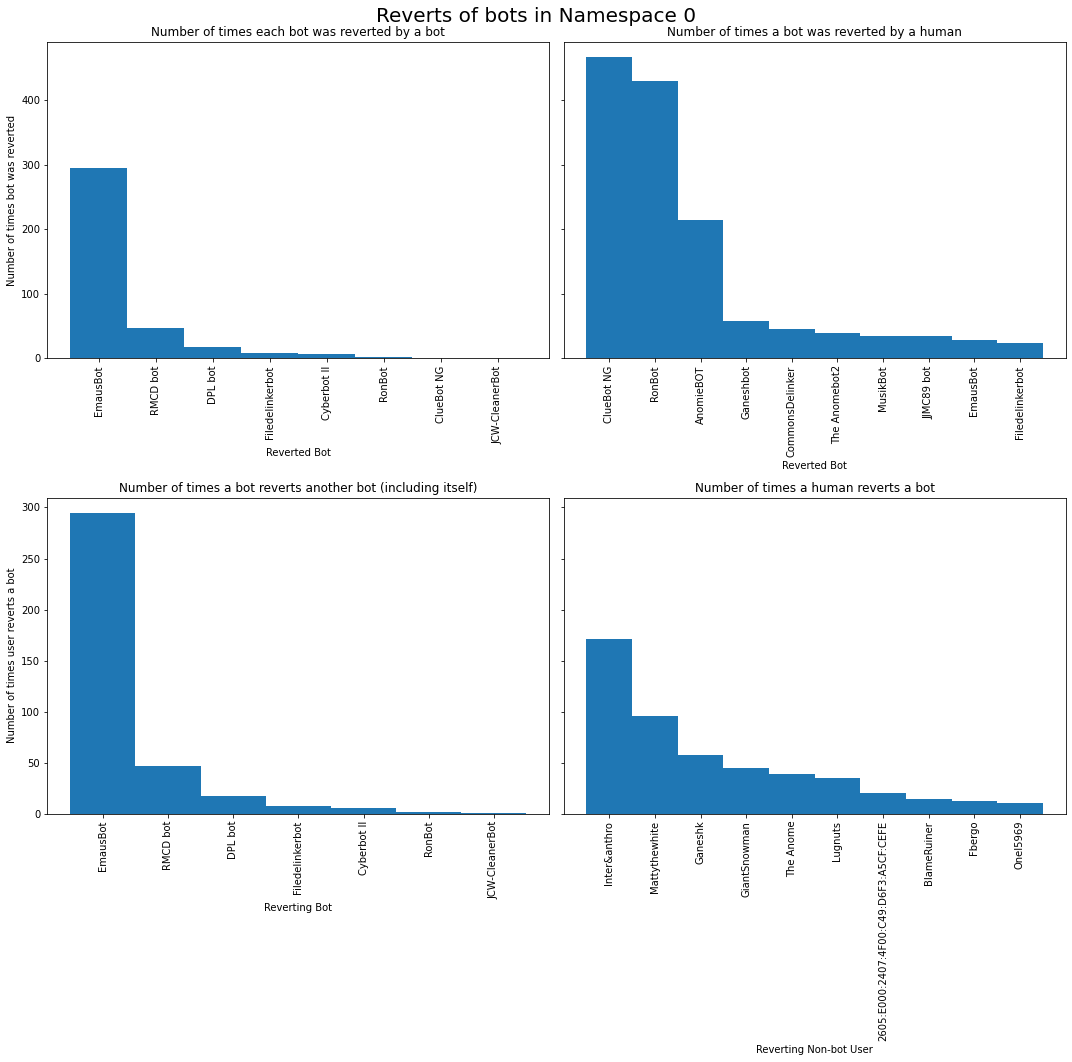

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey = 'row')
fig.suptitle("Reverts of bots in Namespace 0", fontsize = 20)

ax = axes[0,0]
#reverted bots (by other bots)
y = range(len(top_reverted_bots))
ax.bar(y, top_reverted_bots.rev_id, width=1)
ax.set_title("Number of times each bot was reverted by a bot")
ax.set_xlabel("Reverted Bot")
ax.set_ylabel("Number of times bot was reverted")
#ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text}" for row in top_reverted_bots.itertuples()], rotation='vertical')


ax = axes[1,0]
#bots that revert other bots
y = range(len(top_reverter_bots))
ax.bar(y, top_reverter_bots.rev_id, width=1)
ax.set_title("Number of times a bot reverts another bot (including itself)")
ax.set_xlabel("Reverting Bot")
ax.set_ylabel("Number of times user reverts a bot")
#ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text_reverter}" for row in top_reverter_bots.itertuples()], rotation='vertical')


ax = axes[1,1]
y = range(len(top_human_reverters))
ax.bar(y, top_human_reverters.rev_id, width=1)
ax.set_title("Number of times a human reverts a bot")
ax.set_xlabel("Reverting Non-bot User")
#ax.set_ylabel("Number of times bot was reverted")
#ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text_reverter}" for row in top_human_reverters.itertuples()], rotation='vertical')

ax = axes[0,1]
y = range(len(top_bots_reverted_byh))
ax.bar(y, top_bots_reverted_byh.rev_id, width=1)
ax.set_title("Number of times a bot was reverted by a human")
ax.set_xlabel("Reverted Bot")
#ax.set_ylabel("Number of times bot was reverted")
#ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text}" for row in top_bots_reverted_byh.itertuples()], rotation='vertical')

fig.tight_layout()
plt.show()

In [28]:
len(human_bot_reverts[(human_bot_reverts.user_text_reverter == "Inter&anthro") & (human_bot_reverts.user_text != "RonBot")])

0

In [29]:
len(human_bot_reverts[(human_bot_reverts.user_text_reverter == "Mattythewhite") & (human_bot_reverts.user_text != "RonBot")])

3

In [30]:
human_bot_reverts[(human_bot_reverts.user_text_reverter == "Mattythewhite") & (human_bot_reverts.user_text != "RonBot")]

,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
1012,878022236,MusikBot,878030885,878030885,Mattythewhite,False
1116,878449656,ClueBot NG,878481764,878481764,Mattythewhite,False
1147,878533690,ClueBot NG,878572738,878572738,Mattythewhite,False


# RonBot

https://en.wikipedia.org/wiki/User:RonBot

Bot is no longer active, operator has since passed away

tried to look for discussion of malfunctionmost recent talk on user's page is from 2020 and can't find anything there

discussion about brokenimage task possibly being broken in March 2019
https://en.wikipedia.org/wiki/Wikipedia:Bots/Noticeboard/Archive_13#User:RonBot_trouble_possibly_in_need_of_intervention

discussion about footballer category task in July 2018 https://en.wikipedia.org/wiki/Wikipedia:Bot_requests/Archive_76#Association_footballers_not_categorized_by_position


## Random sample of edits reverted by a human

In [31]:
len(human_bot_reverts[human_bot_reverts.user_text == "RonBot"])

429

In [32]:
human_bot_reverts[human_bot_reverts.user_text == "RonBot"].sample(n=20, random_state=1).reset_index()

,index,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
0,537,877208766,RonBot,877271049,877271049,Inter&anthro,False
1,518,877208664,RonBot,877276144,877276144,Inter&anthro,False
2,474,877208212,RonBot,877208417,877208417,Inter&anthro,False
3,587,877209086,RonBot,877269769,877269769,Inter&anthro,False
4,372,877202703,RonBot,877218672,877218672,GiantSnowman,False
5,482,877208346,RonBot,877277625,877277625,Inter&anthro,False
6,686,877277070,RonBot,877295106,877295106,Jmorrison230582,False
7,23,876292953,RonBot,876296168,876296168,Vsmith,False
8,552,877208884,RonBot,877270435,877270435,Inter&anthro,False
9,741,877279563,RonBot,877281409,877281409,Walter Görlitz,False


0. 877208766 on Adil Mezgour page, for task 7. ronbot adds category (footballers not categorized by position). user inter%anthro undoes it, says position category already present. indeed, article does list category "association football forwards" already
1. 877208664 on Adham El Idrissi page, for task 7. ronbot adds category. user inter&anthro deletes it, says position category already present. indeed, category "association football forwards" is already present.
2. 877208212 on Adamo Coulibaly page, for task 7. ronbot adds category (footballers not categorized by position). user Inter%anthro undoes it, says position category already present. indeed, article does list category "association football forwards" already
3. 877209086 on dif page, for task 7. ronbot adds category (footballers not categorized by position). user Inter%anthro undoes it, says position category already present. indeed, article does list category "association football midfielders" already
4. 877202703 same as above, user GiantSnowman reverts, in midfielders category
5. 877208346 same as above, user inter&anthro reverts, in defenders category, edits are 12 hours apart on Jan 7
6. 877277070 same as above, user Jmorrison230582 reverts, in category forwards, edits are 2 hours apart on Jan 7
7. 876292953 on Eastern world page, RonBot adds broken image template. another user vsmith reverts to edit before alleged vandalism that broke the image ***not a malfunction***. edits about 30 mins apart, on Jan 1.
8. 877208884 same footballer edits, reverting user is Inter&anthro, forwards category already present, edits about 12 hours apart on Jan 7
9. 877279563 same footballer edits, reverting user is walter gorlitz, in category defenders, about 10 mins apart 7 Jan
10. 877208746 same footballer edits, reverting user is Inter&anthro, in category defenders, edits about 11 hours apart on Jan 7
11. 877277582 same footballer edits, reverting user Mattythewhite, in category midfielders,  edits about 7 hours apart on Jan 7
12. 876293084 on Johnny Sins page, RonBot adds a BrokenImage template. user Gotitbro reverts, says no broken image. indeed the image seems to be correct.
13. 879469682 on Daksha page, RonBot adds BrokenImage template (task 12). user KylieTastic reverts to a different edit to fix the name of the image. ***not a malfunction***
14. 877208422 same football edits, reverting user is GiantSnowman, in category midfielders, edits are about 3 hours apart Jan 7
15. 877208840 same football edits, reverting user is inter&anthro, in category defenders, 12 hours apart on Jan 7
16. 877209113 same football edits, reverting user is Inter&anthro, in category defenders, edits about 1 hour apart on Jan 7
17. 877208707 same football edits, reverting user Inter&anthro, in category forwards, edits about 11 hours apart on Jan 7
18. 877201219 same football edits, reverting user Mattythewhite, in category forwards, edits about 20 hours apart. first edit is 30 mins before midnight on 6 Jan, second 18:00 on Jan 7
19. 877207378 same football edits, reverting user Daemonickangaroo2018, in category midfielders,  edits about 13 hours apart on Jan 7

# AnomieBOT

https://en.wikipedia.org/wiki/User:AnomieBOT

Practically endless list of tasks, operating since at least 2008, has 5 different accounts to do edits


In [33]:
len(human_bot_reverts[human_bot_reverts.user_text == "AnomieBOT"])

214

In [34]:
human_bot_reverts[human_bot_reverts.user_text == "AnomieBOT"].sample(n=20, random_state=1).reset_index()

,index,rev_id,user_text,revert_id,rev_id_reverter,user_text_reverter,is_self_revert
0,951,877844261,AnomieBOT,877856433,877856433,IndianBio,False
1,1459,879465056,AnomieBOT,879584988,879584988,Mcbjmund,False
2,937,877789628,AnomieBOT,877792114,877792114,SlashFox14,False
3,944,877808458,AnomieBOT,877838653,877838653,SmartTalk,False
4,222,877003846,AnomieBOT,877036217,877036217,NPguy,False
5,155,876751654,AnomieBOT,876878685,876878685,108.51.174.100,False
6,306,877147243,AnomieBOT,877155583,877155583,Dlthewave,False
7,1206,878689146,AnomieBOT,878825529,878825529,JJMC89,False
8,19,876274193,AnomieBOT,876315021,876315021,Drdpw,False
9,150,876737595,AnomieBOT,876819326,876819326,Oknazevad,False


0. 877844261 comment: dating maintenance tags {{Cn}}, has minor flag. added date to {{cn}} template. original edit at 1am. reverting user says "revert to last good version before the IP crap started." 3am. also gets rid of other intervening edits. apparently cn template is the same as citation needed template, just abbreviated.

1. 879465056 comment: rescuing orphaned refs. adds lots of info to a ref which only has a name, including web url, names, tittle, date and accessdate. reverting edit mentions that there are separate entry lists for things? didn't like the change in ref.

2. 877789628 comment: dating maintenance tags: {{fact}}. AnomieBOT adds date to fact tag. 20 mins later, a user comes along and deletes that whole line, including tag, saying that there is no official announcement for the info yet.

3. 877808458 comment: dating maintenance tags: {{Citation needed}}. AnomieBOT adds date to citation needed tag. 5 hours later, a user comes along and deletes the entire sentence, including the tag, basically saying that they couldn't find any supporting info.

4. 877003846 comment: Dating maintenance tags: {{Use dmy dates}}. Anomie BOT changes tag date from April 2019 to January 2019. another user 5 hours later leaves no edit summary, but changes Anomie's tag to April 2015 and changes another date in the article to 2015. I'm guessing Anomie changed the date because it hadn't happened yet, and the other user used the wrong date in the first place. it looks like this template is used to tell editors that dates in the article must have a specific format, and the date is used to show editors when the dates were last checked for the correct format by a human or a bot. I think the human user may have been incorrect about the usage of this template and shouldn't have made that change. ***human error?***

5. 876751654 comment: Dating maintenance tags: {{Cn}}. AnomieBOT adds date to tag. 20 hours later, user says: removing unsourced information about palms which is simply not true.

6. 877147243 comment: Rescuing orphaned refs. AnomieBOT adds lots of info to ref that only had name, including url and title, and access-date. reverting edit an hour later says: as discussed on the talk page, these sources do not discuss social media addiction and are therefore WP:SYN. this edit removes multiple paragraphs, including the citation edited by the bot. ***human conflict***

7. 878689146 comment: fixing reference errors. AnomieBOT removes "\<ref>\</ref>" from the page. reverting edit 20 hours later is completely unrelated, made on line 66 where Anomie's edit was on line 1.

8. 876274193 comment: dating maintenance tags: {{2l}}. AnomieBOT adds date to 2l template. reverting edit 7 hours later after intervening edits, comment says: "reverted to revision 875227896 by Drdpw (talk): All names transferred. (TW)". 2l template appears to be short for too long, same as the {{VeryLong}} template. I think the reverting user disagreed that the template and various other edits were necessary, as the revert target was to the edit before the 2l template was added. ***human conflict***

9. 876737595 comment: dating maintenance tags: {{Cn}} {{Or}}. the bot adds dates to the two tags, which are in the same paragraph. 14 hours later, a user removes the whole paragraph with the comment: remove conspiratorial BS as I have before. ***human conflict***

10. 878030255 comment: fixing reference errors and rescuing orphaned refs ("nvpi" from rev 877888036; "brit" from rev 877888036). the bot adds info to 2 refs that only have a name. it also adds quotation marks to the names. 2 hours later, same user that made previous edit reverts to revision 877888036 without leaving a specific comment. the edit appears to remove both lines that AnomieBOT edited, among several other things. 

10. original edit - anomieBot Fixing reference errors and rescuing orphaned refs ("nvpi" from rev 877888036; "brit" from rev 877888036  on page: “Within Temptation discography” and the user “Feminist” Reverted to revision 877888036 by Ss112 (talk), seems to be making a lot of syntax corrections

11. original edit AnomieBot fixing referencing errors (as it said in the edit summary) and added “{{Black Mirror}}” and the revision that reverted it, removing something else (which i don't know if Anomiebot added), stating that: “Both of these links are already in the article- Twilight Zone is mentioned in prose; Bandersnatch is included in the navbox at the bottom” - all on the page “White Bear”, a Black Mirror episode

12.  Anomiebot was Dating maintenance tags: {{Incoming links}} on the page “Peter Wright” and the revision that reverted it removed what AnomieBot said, saying that theres “no longer incoming links”

13.  Anomiebot was Dating maintenance tags: {{Use dmy dates}} on the page “A Son of Man” and the revision that reverted it removed what AnomieBot said, replacing the date and and a bunch of other small synta things and the user said “lgv” ??? 

14. AnomieBot was Rescuing orphaned refs ("rollingstone.com" from rev 878779391 on the page “Jimmy Iovine” and the revision that reverted it “Reverted to revision 878779391 by C.Fred (talk): Rvv. (TW)”  removing AnomieBots edits and changing other thing about the persons Biography

15. AnomieBot was fixing reference errors again and the revision that reverted it fixed an error that AnomieBot made in the original edit with the tag: Mobile edit Mobile web edit - corrected

16. Anomiebot was Dating maintenance tags: {{lead too short}} on the page “The Ren and Stimpy Show: Time Warp” and the revision that reverted it removed what AnomieBot included, including other edits made before (blanked the page) and “Reverted to revision 872196374 by Cat's Tuxedo (talk): Restore redirect - no indication of notability. (TW)) Tags: Undo New redirect”

17. Anomiebot was Dating maintenance tags: {{By whom?}} on the page “Libre Office” and the revision that reverted it didn’t necessarily remove what AnomieBot added but “rv weird grammar, links to dabs” - corrected, not anomieBots edits 

18. (only revision so far when there are edits in between, so maybe part of a chain?) Anomiebot ws “Rescuing orphaned refs ("MakiRole" from Cloak & Dagger (TV series))”, and a couple edits later, the revision that “reverted” removed a couple of edits (unsure of whether it removed Anomiebots edits), saying that “Reverted to revision 878085310 by Adamstom.97 (talk): No confirmation for Maki f”

19. In the original edit AnomieBot was “Rescuing orphaned refs ("everett" from rev 873063733)” on a page about Brian Frost and the revision that reverted it added a couple things and then removed AnomieBot’s edits to just “everett” stating that its “Entirely appropriate for the lead to summarize the body”.

# summary of bot reverts of humans / human reverts of bots

In [35]:
# isolate data to only data from Jan1-Jan21, reverted w/in 24 hours, revisions by a human

sdf = df[df.day<22]
sdf_reverted = sdf[sdf.is_reverted] # w/o, still include 'none'
sdf_reverted_in_day = sdf_reverted[sdf_reverted.seconds_to_revert.astype('str').astype('int')<86400]
sdf1 = sdf_reverted_in_day[sdf_reverted_in_day.user_is_bot != True ]

namespace0 = sdf1[sdf1.page_namespace == 0]

sdf_another = df[df.user_is_bot]
sdf_another = sdf_another[sdf_another.is_revert]

sdf1 = namespace0.loc[namespace0.is_reverted, ["rev_id", "user_text", "revert_id"]]
sdf1.revert_id = sdf1.revert_id.astype('int')

sdf2 = sdf_another[["rev_id", 'user_text', "is_self_revert"]]

In [36]:
# subset bot-human reverts (cases when bots revert humans) using merge

bot_human_reverts = pd.merge(sdf1, sdf2, 
             how='inner', 
             left_on='revert_id', 
             right_on='rev_id', 
             suffixes=('', '_reverter')
)

In [37]:
top_humans_revertedbybot = bot_human_reverts.groupby(["user_text"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index().head(10)

In [38]:
top_bots_reverting_humans = bot_human_reverts.groupby(["user_text_reverter"], as_index = False).count().sort_values("rev_id", ascending=False).reset_index().head(10)

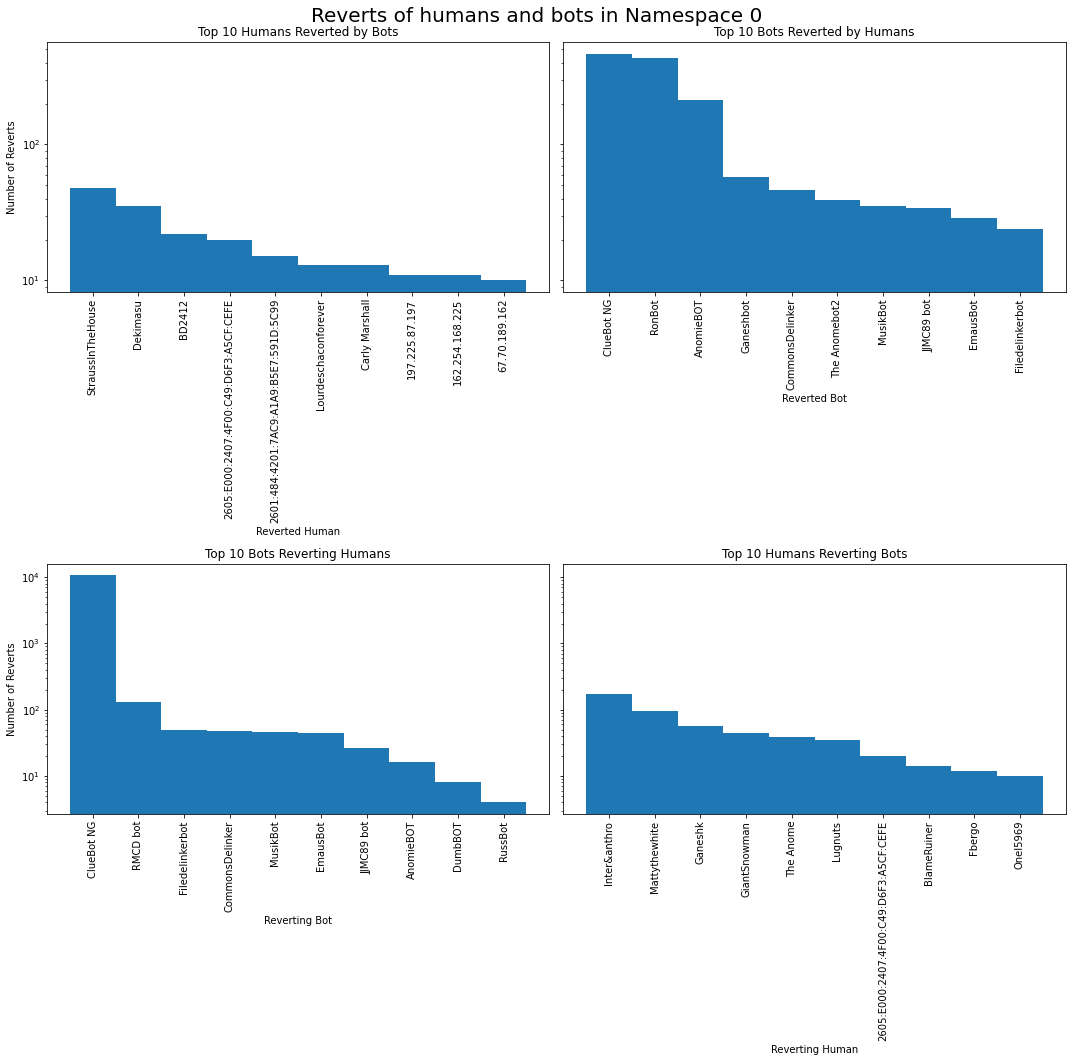

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey = 'row')
fig.suptitle("Reverts of humans and bots in Namespace 0", fontsize = 20)

ax = axes[0,0]
y = range(len(top_humans_revertedbybot))
ax.bar(y, top_humans_revertedbybot.rev_id, width=1)
ax.set_title("Top 10 Humans Reverted by Bots")
ax.set_xlabel("Reverted Human")
ax.set_ylabel("Number of Reverts")
ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text}" for row in top_humans_revertedbybot.itertuples()], rotation='vertical')

ax = axes[1,0]
y = range(len(top_bots_reverting_humans))
ax.bar(y, top_bots_reverting_humans.rev_id, width=1)
ax.set_title("Top 10 Bots Reverting Humans")
ax.set_xlabel("Reverting Bot")
ax.set_ylabel("Number of Reverts")
ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text_reverter}" for row in top_bots_reverting_humans.itertuples()], rotation='vertical')


ax = axes[1,1]
y = range(len(top_human_reverters))
ax.bar(y, top_human_reverters.rev_id, width=1)
ax.set_title("Top 10 Humans Reverting Bots")
ax.set_xlabel("Reverting Human")
#ax.set_ylabel("Number of times bot was reverted")
ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text_reverter}" for row in top_human_reverters.itertuples()], rotation='vertical')

ax = axes[0,1]
y = range(len(top_bots_reverted_byh))
ax.bar(y, top_bots_reverted_byh.rev_id, width=1)
ax.set_title("Top 10 Bots Reverted by Humans")
ax.set_xlabel("Reverted Bot")
#ax.set_ylabel("Number of times bot was reverted")
ax.set_yscale('log')
ax.set_xticks(y)
ax.set_xticklabels([f"{row.user_text}" for row in top_bots_reverted_byh.itertuples()], rotation='vertical')

fig.tight_layout()
plt.show()

# graph of percentages of edits reverted for each bot

In [40]:
bots_namespace0 = df[df.user_is_bot]
bots_namespace0 = bots_namespace0[bots_namespace0.page_namespace == 0]
bots_namespace0 = bots_namespace0[bots_namespace0.day<22]
sdf1 = bots_namespace0.groupby("user_text", as_index = False).count()
sdf1["total_edits"] = sdf1["rev_id"]
sdf1 = sdf1[["user_text", "total_edits"]]

sdf2 = human_bot_reverts.groupby('user_text', as_index = False).count()
sdf2["edits_reverted_by_human"] = sdf2["rev_id"]
sdf2 = sdf2[["user_text", "edits_reverted_by_human"]]

In [41]:
bot_summary = pd.merge(sdf1, sdf2, 
             how='outer', 
             left_on='user_text', 
             right_on='user_text', 
)
bot_summary['edits_reverted_by_human'] = bot_summary['edits_reverted_by_human'].fillna(0)

In [42]:
def f(data):
    val = data[2] / data[1]
    return val

bot_summary["pct_human_reverted"] = bot_summary.apply(f, axis=1)

In [43]:
top_pct_reverted = bot_summary.sort_values("pct_human_reverted", ascending=False).head(10)

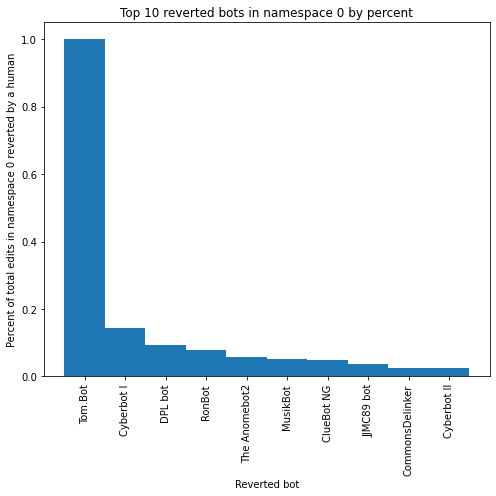

In [44]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

y = range(len(top_pct_reverted))
axes.bar(y, top_pct_reverted.pct_human_reverted, width=1)
axes.set_title("Top 10 reverted bots in namespace 0 by percent")
axes.set_xlabel("Reverted bot")
axes.set_ylabel("Percent of total edits in namespace 0 reverted by a human")
#axes.set_yscale('log')
axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text}" for row in top_pct_reverted.itertuples()], rotation='vertical')

plt.tight_layout()
plt.show()

In [45]:
bot_summary.mean()

total_edits                2160.653061
edits_reverted_by_human      30.244898
pct_human_reverted            0.035023
dtype: float64

In [46]:
# averages without Tom bot (an outlier)
bot_summary[bot_summary.pct_human_reverted < .5].mean()

total_edits                2205.645833
edits_reverted_by_human      30.854167
pct_human_reverted            0.014919
dtype: float64

# adding more columns to summary table

In [47]:
bot_self_reverts = bot_bot_reverts[bot_bot_reverts.user_text == bot_bot_reverts.user_text_reverter]
bot_non_self_reverts = bot_bot_reverts[bot_bot_reverts.user_text != bot_bot_reverts.user_text_reverter]

In [48]:
bot_self_reverts = bot_self_reverts.groupby(['user_text'], as_index = False).count()
bot_self_reverts["self_reverts"] = bot_self_reverts["rev_id"]
bot_self_reverts = bot_self_reverts[['user_text','self_reverts']]

In [50]:
bot_non_self_reverts = bot_non_self_reverts.groupby(['user_text'], as_index = False).count()
bot_non_self_reverts["non_self_reverts"] = bot_non_self_reverts["rev_id"]
bot_non_self_reverts = bot_non_self_reverts[['user_text','non_self_reverts']]

In [51]:
bot_summary = pd.merge(bot_summary, bot_self_reverts, 
             how='outer', 
             left_on='user_text', 
             right_on='user_text', 
             suffixes = ('',''),
)

In [52]:
bot_summary = pd.merge(bot_summary, bot_non_self_reverts, 
             how='outer', 
             left_on='user_text', 
             right_on='user_text', 
             suffixes = ('',''),
)

In [53]:
bot_summary['self_reverts'] = bot_summary['self_reverts'].fillna(0)
bot_summary['non_self_reverts'] = bot_summary['non_self_reverts'].fillna(0)
bot_summary['self_reverts'] = bot_summary['self_reverts'].astype(int)
bot_summary['non_self_reverts'] = bot_summary['non_self_reverts'].astype(int)
bot_summary['edits_reverted_by_human'] = bot_summary['edits_reverted_by_human'].astype(int)
bot_summary = bot_summary[["user_text","total_edits","edits_reverted_by_human","pct_human_reverted", "non_self_reverts", "self_reverts"]]

In [54]:
bot_summary

,user_text,total_edits,edits_reverted_by_human,pct_human_reverted,non_self_reverts,self_reverts
0,AnomieBOT,11807,214,0.018125,0,0
1,AnomieBOT III,4,0,0.000000,0,0
2,BattyBot,113,1,0.008850,0,0
3,Bender the Bot,4430,1,0.000226,0,0
4,Bot1058,4974,3,0.000603,0,0
5,Cewbot,32,0,0.000000,0,0
6,Citation bot,7986,18,0.002254,0,0
7,CitationCleanerBot,5154,1,0.000194,0,0
8,ClueBot NG,9285,466,0.050188,1,0
9,CommonsDelinker,1823,46,0.025233,0,0
